In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split

In [2]:
dataset = torchvision.datasets.CIFAR10(root='data/',download=True,transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4,padding_mode='reflect'), # augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # CxHxW
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

test_dataset = torchvision.datasets.CIFAR10(root='data/',train = False,download=True,transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4,padding_mode='reflect'), # augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # CxHxW
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
val_ratio = 0.2
train_dataset, val_dataset = random_split(dataset,[int((1-val_ratio)*len(dataset)), int(val_ratio*len(dataset))])
batch_size =  32 #higher batch size is better
train_dl = DataLoader(train_dataset,batch_size,shuffle=True,pin_memory=True)
val_dl = DataLoader(val_dataset,batch_size,shuffle=True,pin_memory=True)
test_dl = DataLoader(test_dataset,batch_size,pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


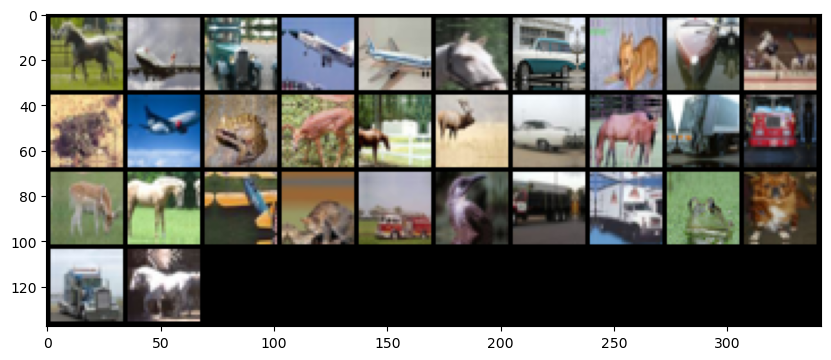

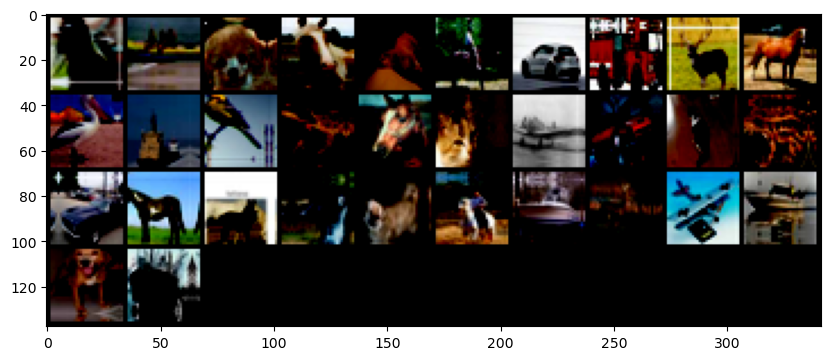

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def denormalize(images,means,std_div):
  means = torch.tensor(means).reshape(1,3,1,1)
  std_div = torch.tensor(std_div).reshape(1,3,1,1)
  return images*std_div + means

def show_preview(dl,normalized):
  for images,labels in dl:
    fig, ax = plt.subplots(figsize=(10,10))
    if(normalized):
      images = denormalize(images,(0.5,0.5,0.5),(0.5,0.5,0.5))
    ax.imshow(make_grid(images,10).permute(1,2,0)) #H,W,C
    break
show_preview(train_dl,1)
show_preview(train_dl,0)

#they appear dark because we had applied normalization

In [5]:
def get_default_devices():
  return torch.device("cuda").type if torch.cuda.is_available() else torch.device("cpu")

def to_device(data,device):
  if(isinstance(data,(list,tuple))):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)
  #non blocking means you dont want to block execution of code when transferring code

class DeviceDataLoader():
  ''' wrapper around dataloaders to transfer batches to specified devices'''
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__(self):
    return len(self.dl)

device = get_default_devices()
train_dl = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(test_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

### Network architecture

resnets: residual blocks
inception
mobilenet

model = ResnetX(in_channels,num_classes)
logits = model(images)

In [17]:
from typing import OrderedDict
import torch.nn as nn
import torch.nn.functional as F


def conv_block(in_channels, out_channels, use_pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),  # avoid skewness in a particular channel
              nn.ReLU(inplace=True)]
    if use_pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super().__init__()
        self.layers = nn.ModuleList()
        current_channels = in_channels
        for _ in range(num_layers):
            self.layers.append(conv_block(current_channels, growth_rate))
            current_channels += growth_rate  # increase channels with each layer

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            out = layer(torch.cat(features, dim=1))  # concatenate along the channel dimension
            features.append(out)
        return torch.cat(features, dim=1)  # concatenate all feature maps at the end


class DenseNetX(nn.Module):
    def __init__(self, in_channels, num_classes, growth_rate=32, num_layers_per_block=4):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, use_pool=True)
        self.dense1 = DenseBlock(num_layers=num_layers_per_block, in_channels=128, growth_rate=growth_rate)
        self.transition1 = nn.Sequential(nn.Conv2d(128 + num_layers_per_block * growth_rate, 256, kernel_size=1),
                                         nn.AvgPool2d(2))

        self.dense2 = DenseBlock(num_layers=num_layers_per_block, in_channels=256, growth_rate=growth_rate)
        self.transition2 = nn.Sequential(nn.Conv2d(256 + num_layers_per_block * growth_rate, 512, kernel_size=1),
                                         nn.AvgPool2d(2))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.dense1(out)
        out = self.transition1(out)
        out = self.dense2(out)
        out = self.transition2(out)
        out = self.classifier(out)
        return out


In [25]:
model = DenseNetX(3,10)
# model
# list(model.parameters())

In [8]:
!pip install torchview

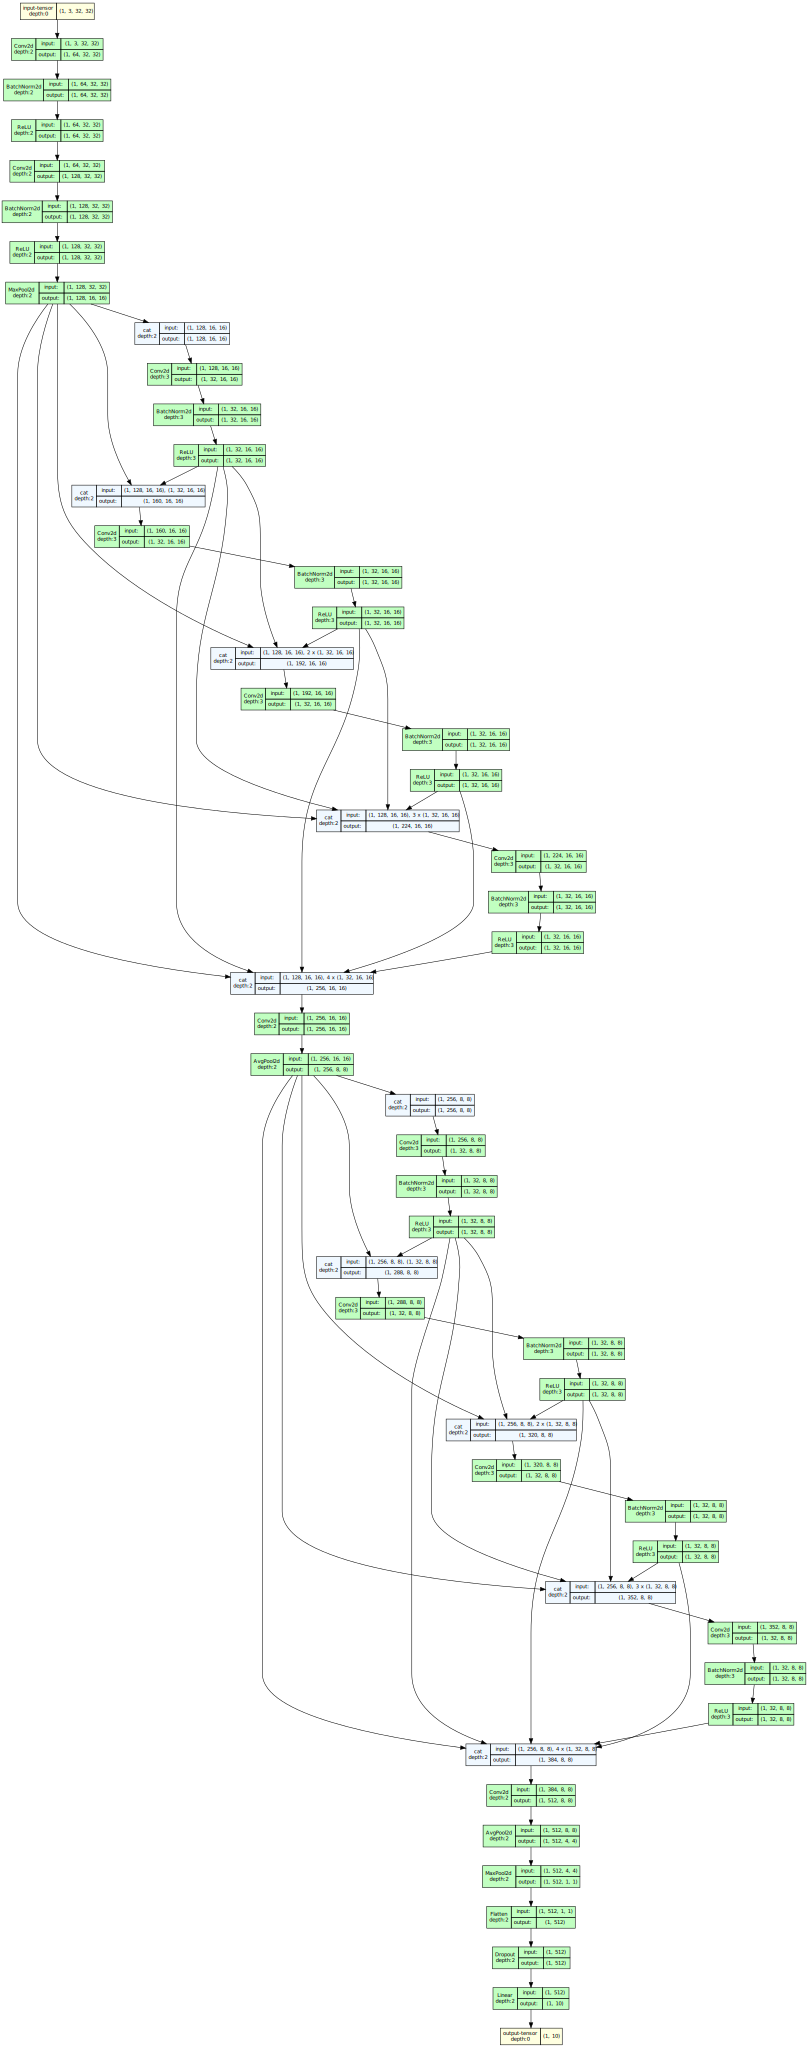

In [26]:
from torchview import draw_graph
model_graph = draw_graph(model, torch.zeros(1, 3, 32, 32))
model_graph.visual_graph

### Training the network

In [10]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [31]:
def accuracy(output, labels):
    predClassId = torch.argmax(output, dim=1)
    return (predClassId == labels).float().mean().item()

def evaluate(model, dl, loss_func):
    model.eval()
    with torch.no_grad():
        batch_losses, batch_accs = [], []

        for images, labels in dl:
            out = model(images)
            loss = loss_func(out, labels)
            batch_losses.append(loss)

            # Calculate accuracy
            acc = accuracy(out, labels)
            batch_accs.append(acc)

        val_loss = torch.stack(batch_losses).mean().item()
        val_acc = torch.tensor(batch_accs).mean().item()
        return val_loss, val_acc

def train(model, train_dl, val_dl, epochs, max_lr, loss_function, optim):
    optimizer = optim(model.parameters(), lr=max_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    early_stopper = EarlyStopper(patience=3, min_delta=10)

    results = []

    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []

        for images, labels in train_dl:  # for every batch
            optimizer.zero_grad()
            out = model(images)
            loss = loss_function(out, labels)
            train_loss.append(loss)
            loss.backward()  # delta loss/delta_model_parameters
            optimizer.step()
            lrs.append(optimizer.param_groups[0]['lr'])
        
        scheduler.step()

        epoch_train_loss = torch.stack(train_loss).mean().item()

        # Evaluate on validation data
        val_loss, val_acc = evaluate(model, val_dl, loss_function)
        if early_stopper.early_stop(val_loss):
            break

        # Store results
        results.append({'avg_train_loss': epoch_train_loss, 'avg_val_loss': val_loss, 'avg_val_acc': val_acc, 'lrs': lrs})

        # Print progress for each epoch
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Training Loss: {epoch_train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}\n")

    return results

In [32]:
epochs = 60
max_lr = 1e-2
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD

In [33]:
results = train(model, train_dl, val_dl, epochs, max_lr, loss_func, optimizer)

Epoch [1/40]
Training Loss: 1.5513
Validation Loss: 1.3264
Validation Accuracy: 0.5305

Epoch [2/40]
Training Loss: 1.1360
Validation Loss: 1.0555
Validation Accuracy: 0.6238

Epoch [3/40]
Training Loss: 0.9345
Validation Loss: 0.9158
Validation Accuracy: 0.6814

Epoch [4/40]
Training Loss: 0.8163
Validation Loss: 1.1417
Validation Accuracy: 0.6193

Epoch [5/40]
Training Loss: 0.7303
Validation Loss: 0.8161
Validation Accuracy: 0.7119

Epoch [6/40]
Training Loss: 0.6615
Validation Loss: 0.7578
Validation Accuracy: 0.7379

Epoch [7/40]
Training Loss: 0.6136
Validation Loss: 0.8199
Validation Accuracy: 0.7192

Epoch [8/40]
Training Loss: 0.5683
Validation Loss: 0.6377
Validation Accuracy: 0.7774

Epoch [9/40]
Training Loss: 0.5338
Validation Loss: 0.6398
Validation Accuracy: 0.7796

Epoch [10/40]
Training Loss: 0.5004
Validation Loss: 0.6819
Validation Accuracy: 0.7638

Epoch [11/40]
Training Loss: 0.4747
Validation Loss: 0.6049
Validation Accuracy: 0.7949

Epoch [12/40]
Training Loss: 0

In [35]:
torch.save(model.state_dict(), "densenet.pth")

In [40]:
model.load_state_dict(torch.load("densenet.pth"))

/tmp/ipykernel_2807413/2281401842.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("densenet.pth"))


<All keys matched successfully>

In [41]:
additional_epochs = 30
new_results = train(model, train_dl, val_dl, additional_epochs, 1e-3, loss_func,optimizer)

Epoch [1/30]
Training Loss: 0.3541
Validation Loss: 0.5440
Validation Accuracy: 0.8262

Epoch [2/30]
Training Loss: 0.3212
Validation Loss: 0.6045
Validation Accuracy: 0.8014

Epoch [3/30]
Training Loss: 0.3007
Validation Loss: 0.5658
Validation Accuracy: 0.8206

Epoch [4/30]
Training Loss: 0.2898
Validation Loss: 0.5565
Validation Accuracy: 0.8244

Epoch [5/30]
Training Loss: 0.2772
Validation Loss: 0.4637
Validation Accuracy: 0.8460

Epoch [6/30]
Training Loss: 0.2637
Validation Loss: 0.4659
Validation Accuracy: 0.8490

Epoch [7/30]
Training Loss: 0.2547
Validation Loss: 0.4324
Validation Accuracy: 0.8482

Epoch [8/30]
Training Loss: 0.2394
Validation Loss: 0.5183
Validation Accuracy: 0.8300

Epoch [9/30]
Training Loss: 0.2278
Validation Loss: 0.4640
Validation Accuracy: 0.8466

Epoch [10/30]
Training Loss: 0.2187
Validation Loss: 0.4419
Validation Accuracy: 0.8590

Epoch [11/30]
Training Loss: 0.2089
Validation Loss: 0.4584
Validation Accuracy: 0.8524

Epoch [12/30]
Training Loss: 0

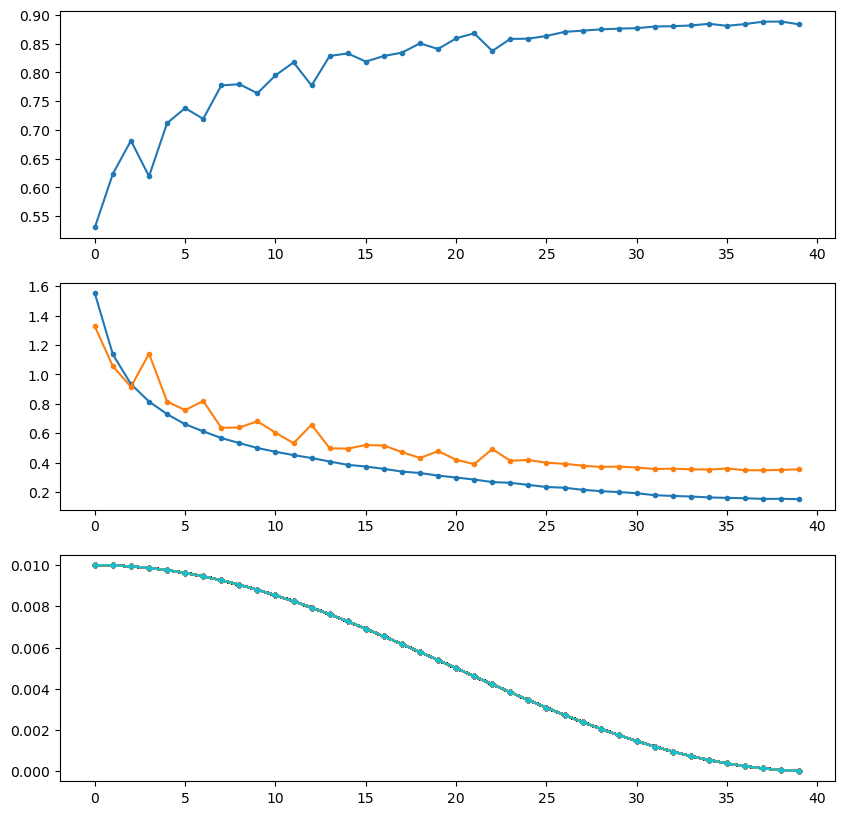

In [42]:
import matplotlib.pyplot as plt

def plot(results, pairs):
    fig, axes = plt.subplots(len(pairs), figsize=(10, 10))  # Adjust height for multiple plots
    for i, pair in enumerate(pairs):
        for title, graphs in pair.items():
            axes[i].set_title = title
            axes[i].legend = graphs
            for graph in graphs:
                axes[i].plot([result[graph] for result in results],".-")

# Example input
plot(results, [{"Accuracies vs epochs": ["avg_val_acc"]},
               {"Losses vs epochs": ["avg_train_loss", "avg_val_loss"]},
               {"Learning rate vs Batches": ["lrs"]}])


In [43]:
_ , val_acc = evaluate(model,test_dl,loss_func)
print(val_acc)

0.894568681716919
